In [1]:
import sys
sys.path.append("/tmp/pycharm_project")

from scheme.plotting import _draw_network
from scheme.networks import duplication_divergence_graph, annotate_cell_type_specific_gene_modules, \
    produce_celltype_perturbed_gene_backbone, count_gene_types
from scheme.util import StatefulPRNGKey

import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

# Random Seed
seed = 1234567890

rng_key = StatefulPRNGKey(seed)

/opt/conda/envs/scheme_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Number of genes to generate
n_genes = 2500
# Number of "cell types" to generate
n_celltypes = 3
# The probability of a "mutation" event occuring when generating gene interaction networks. (adding or removing edges when "duplicating")
p_network_mutation = 0.4
# Probability of a gene transitioning into a receptor
p_receptor = 0.05

# Base Topology
Topology of molecular interaction networks: https://link.springer.com/article/10.1186/1752-0509-7-90
- Gene networks are multi-scale
- Barabasi-Albert or Duplication-Divergence graphs are scale-free and work okay
-

On the evolution of scale-free topologies with a gene regulatory network model: https://www.sciencedirect.com/science/article/pii/S0303264709001087?casa_token=pbVT3sbkH1sAAAAA:qydQn7nE5-7tJlVZem4ZNQJUm2qzNlyQlGBuVlgbgJL7wH1B2y4caxSLiprCWCkcfbnEP2ig8g
- Duplication-divergence graphs are useful to make a scale-free network that are realistic

Scale-free networks in cell biology: https://journals.biologists.com/jcs/article/118/21/4947/28519/Scale-free-networks-in-cell-biology
-

Artificial Gene Regulatory
Networks—A Review: https://ieeexplore.ieee.org/abstract/document/8662826

In [13]:
G = duplication_divergence_graph(n_genes, p_network_mutation, p_receptor, rng_key)
print("Gene statistics")
counts = count_gene_types(G)
print(f"Ligands: {counts['ligand']} ({counts['ligand'] / n_genes * 100:.2f}%) Receptors: {counts['receptor']} ({counts['receptor'] / n_genes * 100:.2f}%)")

Gene statistics
Ligands: 911 (36.44%) Receptors: 150 (6.00%)


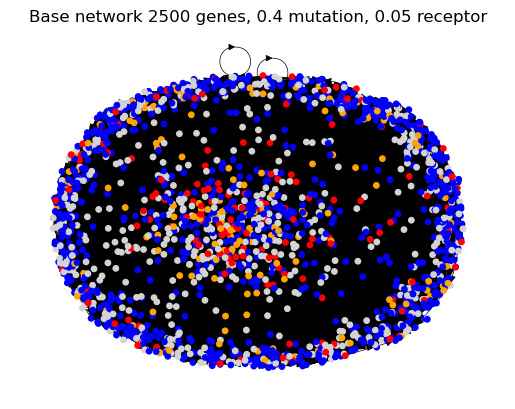

<Figure size 640x480 with 0 Axes>

In [14]:
_draw_network(G, f"Base network {n_genes} genes, {p_network_mutation} mutation, {p_receptor} receptor")

/opt/conda/envs/scheme_env/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


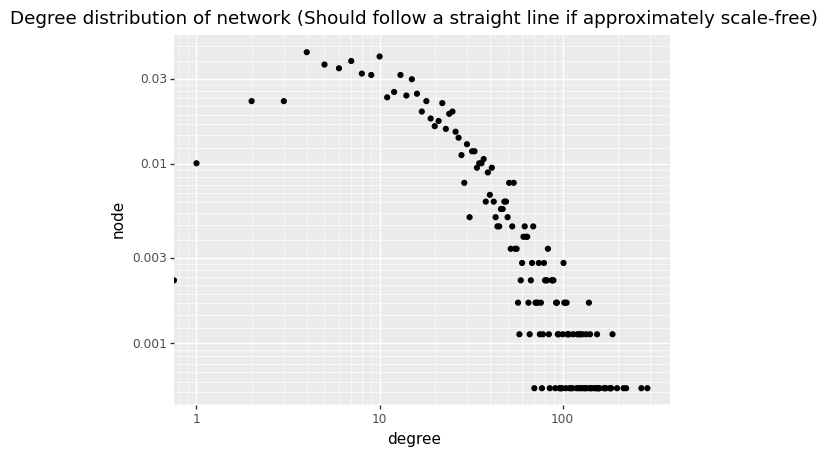

<ggplot: (8780074989306)>

In [16]:
# See if network follows scale-free properties (power-law distributed degrees)
nodes = [n for n in G.nodes]
# Count number of nodes with each degree
df = pd.DataFrame({
    'node': nodes,
    'degree': map(G.degree, nodes)
})
df = df.groupby('degree').count().reset_index()
df['node'] = df['node'] / df['node'].sum()  # Calculate the probability of a node having a given degree

# Estimate the gamma parameter of the scale-free network  FIXME: Simple OLS doesn't work well
# https://en.wikipedia.org/wiki/Scale-free_network
P_k = df['node']
k = df['degree']

#model = sm.OLS(-1 * np.log10(P_k), sm.add_constant(-1 * np.log10(k))).fit()
#gamma = model.params[1]
#print(gamma)

#df['expected'] = df['degree']**(gamma)

# Should look like an approximately straight line
(ggplot(df, aes(x='degree', y='node'))
 + geom_point()
# + geom_line(aes(y='expected'))
 + scale_x_log10()
 + scale_y_log10()
 + ggtitle(f"Degree distribution of network (Should follow a straight line if approximately scale-free)"))

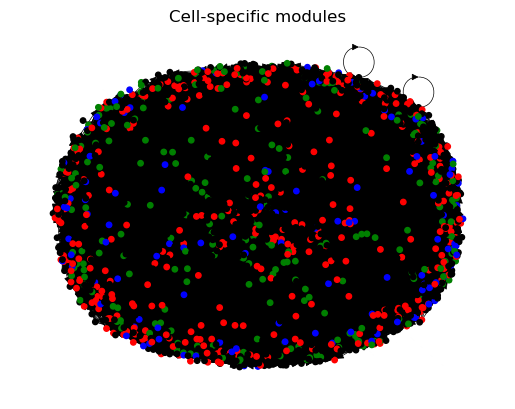

<Figure size 640x480 with 0 Axes>

In [17]:
G = annotate_cell_type_specific_gene_modules(G, n_celltypes, rng_key)

_draw_network(G, "Cell-specific modules", colors={
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    None: 'black'
}, color_prop='cell_type')

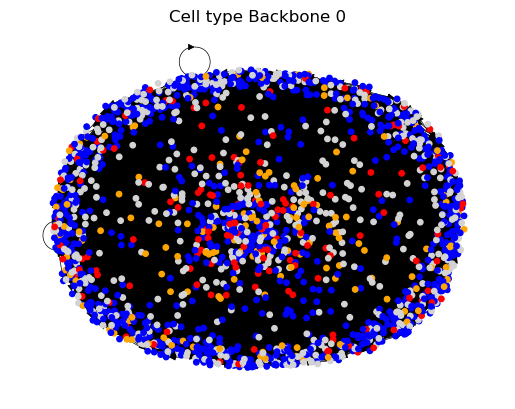

<Figure size 640x480 with 0 Axes>

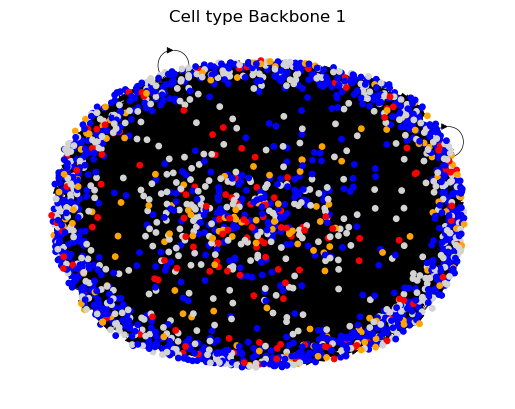

<Figure size 640x480 with 0 Axes>

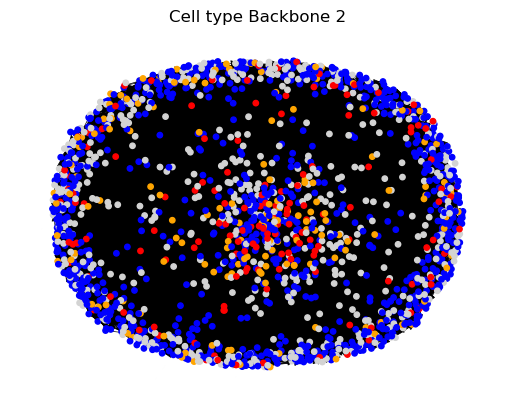

<Figure size 640x480 with 0 Axes>

In [18]:
for i in range(n_celltypes):
    specific_G = produce_celltype_perturbed_gene_backbone(G, i, rng_key)
    _draw_network(specific_G, f"Cell type Backbone {i}")
